## Supervised Machine Learning Fundamentals -Travel Insurance Prediction

An insurance company has started offering a new travel insurance package to their customers which includes covid-19 protection. With almost 2000 historical customer records provided the insurance company has asked for an intelligent model that would predict if new customers will be interested in the insurance package. As a data scientist we are trusted with this task. 

The aim of the assignment is to build a machine learning model which would effectively predict customer interest in the new insurance package.

Objectives:

- Perform Exploratory Data Analysis on the provided dataset
- Form and test hypotheses that would give insights into feature importance 
- Establish metrics by which the classification algorithms would be assessed 
- Build and test classification algorithms and choose the best performing ones based on established metrics

Module imports

In [1]:
import sys
import os

sys.path.append("src")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical inference modules
from scipy.stats import chi2_contingency


# Machine learning modules
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

# local modules
import utils as utl
import plots as plot

In [2]:
# Set scientific Numpy notation off
np.set_printoptions(suppress=True)

Import the dataset

In [3]:
data = "TravelInsurancePrediction.csv"
df = pd.read_csv(data, index_col=0)

In [4]:
df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1987 non-null   int64 
 1   Employment Type      1987 non-null   object
 2   GraduateOrNot        1987 non-null   object
 3   AnnualIncome         1987 non-null   int64 
 4   FamilyMembers        1987 non-null   int64 
 5   ChronicDiseases      1987 non-null   int64 
 6   FrequentFlyer        1987 non-null   object
 7   EverTravelledAbroad  1987 non-null   object
 8   TravelInsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 155.2+ KB


We have a total of 1987 observations with 9 features each - 3 numerical and 6 categorical

In [6]:
print(f"Total number of missing values in the dataset: {df.isnull().sum().sum()}")
print(f"Total number of duplicated values: {df.duplicated().sum()}")

Total number of missing values in the dataset: 0
Total number of duplicated values: 738


There are a total of 738 duplicated values, considering that there is no mention on oversampling in the description of the dataset and the fact that due to categories the duplication is not unlikely to occur, we will leave the values and not treat them as duplicated.

## EDA

For the ease of analysis we'll split the categorical and numerical columns and do abit of clean up for naming convention

In [7]:
df[["ChronicDiseases", "TravelInsurance"]] = df[
    ["ChronicDiseases", "TravelInsurance"]
].astype("object")
df = df.rename({"Employment Type": "EmployementType"}, axis=1)


categorical_clm = df.select_dtypes(include=["object", "category"]).columns
numerical_clm = df.select_dtypes(exclude=["object", "category"]).columns

### Feature explanation


- "Age" - Age Of The Customer
- "Employment Type" - The Sector In Which Customer Is Employed
- "GraduateOrNot" - Whether The Customer Is College Graduate Or Not
- "AnnualIncome" - The Yearly Income Of The Customer In Indian Rupees[Rounded To Nearest 50 Thousand Rupees]
- "FamilyMembers" - Number Of Members In Customer's Family
- "ChronicDisease" - Whether The Customer Suffers From Any Major Disease Or Conditions Like Diabetes/High BP or Asthama,etc.
- "FrequentFlyer" - Derived Data Based On Customer's History Of Booking Air Tickets On at least 4 Different Instances In The Last 2 Years[2017-2019].
- "EverTravelledAbroad" - Has The Customer Ever Travelled To A Foreign Country[Not Necessarily Using The Company's Services]
- "TravelInsurance" - Did The Customer Buy Travel Insurance Package During Introductory Offering Held In The Year 2019.

### Exploratory visuals

#### Categorical features

Since 6 of the features are categorical lets build a countplot to get some insight into the ratios for the features and if there are any obvious indications on travel insurance preference.

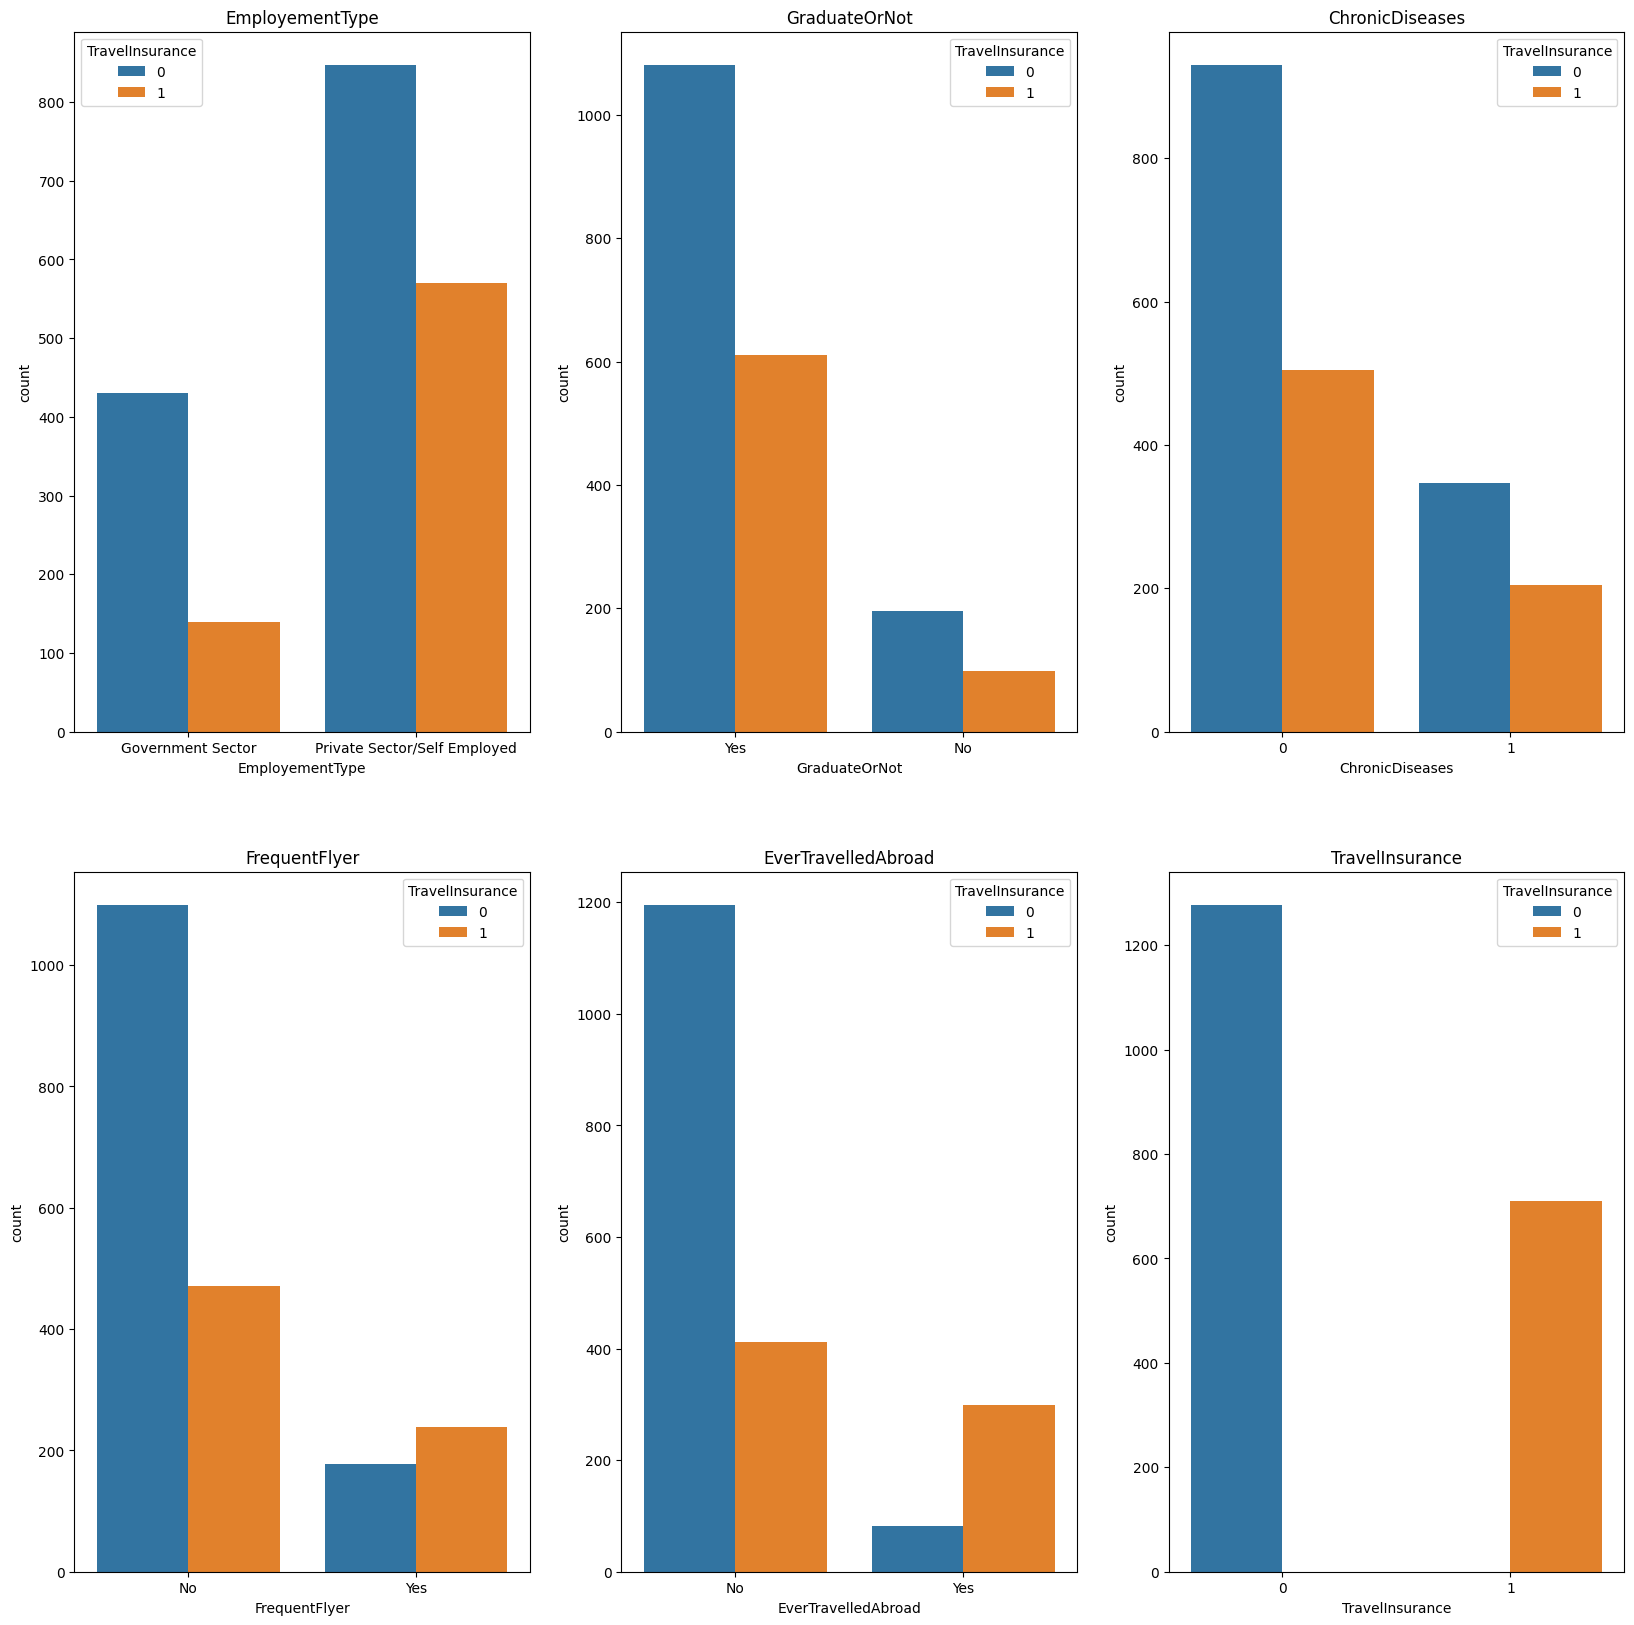

In [8]:
plot.plot_categorical_columns(df, categorical_clm, "TravelInsurance")

Firstly, we can see the inbalance in the target - Travel Insurance. As expected amount of customers who purchased travel insurance is lower than those who did not, the inbalance itself is worth noting as the inabalance will have to addressed while modelling, adjustments for class weights will need to be done for certain algorithms.

Clear indicators on potential interest are customers who are frequent flyers and customers who ever traveled abroad as most who are fit the category have purchased travel insurance before.

Less obvious are private sector/self_employed and customers with chronic diseases as there is a small visual bias towards opting for travel insurance. We will check the hypothesis

#### Numerical features

To analyze numerical features we will plot a set of boxplots

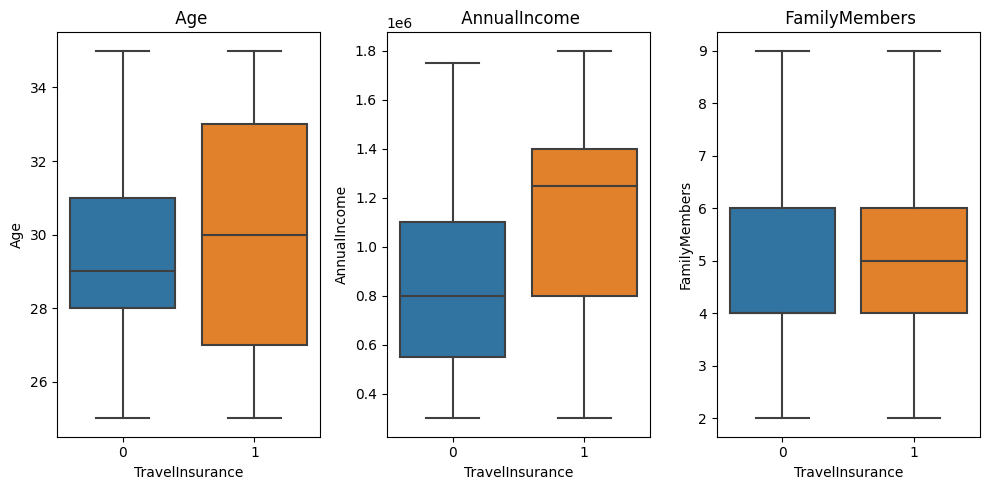

In [9]:
plot.plot_numerical_columns(df, numerical_clm, "TravelInsurance")

Looking at the boxplots for customers who have previously purchased insurance there are no extreme separation between categories. The age spread is higher, the annual income median value of customer who have purchased travel insurance is also higher, which would be expected as no expenses are spared when traveling. 
And it seems the number of family members has no clear difference.

Worth noting that the age spread in the dataset is 25 to 35, so the data covers fairly young portion of customer base.

#### Feature correlation

To double check categorical feature association we will assemble and print categorical feature association matrix based on Cramers V test.

Encode categorical features and assemble the matrix

In [10]:
label=LabelEncoder()
data_labeled=pd.DataFrame()

for i in df[categorical_clm]:
    data_labeled[i]=label.fit_transform(df[i])

In [11]:
cat_corr=utl.matrix_build(data_labeled)

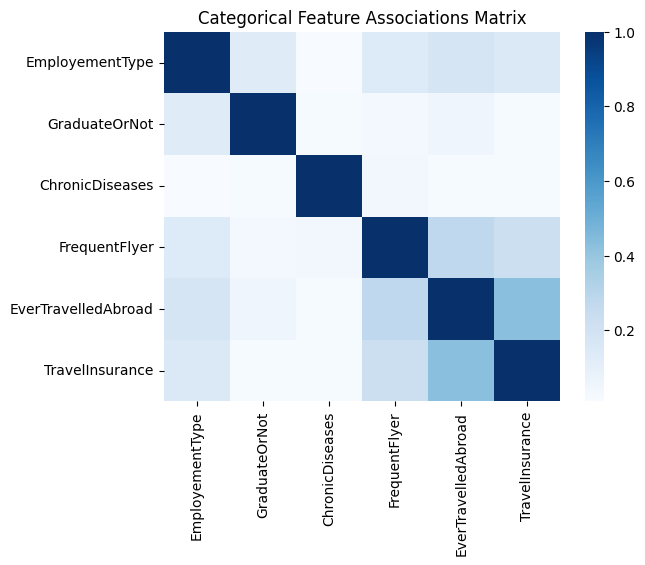

In [12]:
ax=sns.heatmap(cat_corr,cmap='Blues')
ax.set_title("Categorical Feature Associations Matrix");

Observing the heatmap we can identify signs some positive association between our target - 'Travel Insurance' and Frequent Flyers and customers who have traveled abroad before. Nothing else stands out, so we covered most of the features with bar and box plots.

## Hypothesis testing

To further build on EDA observations we will perform hypothesis testing to get a better insight into the dataset. From the EDA observation we will check the less obvious cases: Chronic diseases and Graduation status 

Following questions will be answered :
 - Is there statistically significant relationship between the presence of chronic diseases and travel insurance purchase.
 - Is there a statistically significant relationship between graduate status and travel insurance purchase.


 Since we are focusing on categorical data, our method of choice will be Chi-square method. Following assumptions have to be met:
 
 - Both variables are categorical: for both cases the variables are categorical (Yes/No and 1/0)
 - All observations are independent: since the dataset is assembled from historical data of previous sales it is reasonable to assume that each observation was not influenced by other. 1 customer - one set of independent observations
 - Cells in the contingency table are mutually exclusive: an individual observation cannot belong to more than one cell. In this case each observation is treated as a one off event with no repeated observations of the same sample.
 - Expected value of cells should be 5 or greater in 80% of the cells: as seen from contingency tables that is the case

Hypothesis 1:

- There is statistically significant relationship between the presence of chronic diseases and travel insurance purchase.

Alternative null hypothesis H0:

- There is no statistically significant relationship between the presence of chronic diseases and travel insurance purhcase.

In [13]:
cont_table = pd.crosstab(df["GraduateOrNot"], df["TravelInsurance"])
chi2, p, _, _ = chi2_contingency(cont_table)
print(cont_table)
print(f"\n P-value for the Chi2 test: {p:.2f}")

TravelInsurance     0    1
GraduateOrNot             
No                196   99
Yes              1081  611

 P-value for the Chi2 test: 0.44


With an observed P value of 0.44 we cannot reject the null hypothesis and infer that there is no significant relationship between customers who are College graduates and their preference on Travel Insurance

Hypothesis 2:

- There is statistically significant relationship between customer graduate status and travel insurance purchase.

Alternative null hypothesis H0:

- There is no statistically significant relationship between customer graduate status and travel insurance purhcase.

In [14]:
cont_table = pd.crosstab(df["ChronicDiseases"], df["TravelInsurance"])
chi2, p, _, _ = chi2_contingency(cont_table)
print(cont_table)
print(f"\n P-value for the Chi2 test: {p:.2f}")

TravelInsurance    0    1
ChronicDiseases          
0                930  505
1                347  205

 P-value for the Chi2 test: 0.45


With an observed P value of 0.44 we cannot reject the null hypothesis and infer that there is no significant relationship between customers who have Chronic Diseases and their preference on Travel Insurance

## Machine learning

### Classification metrics

The machine learning task at hand is a classification problem, so we will try and test multiple algorithms, we will pick the best performers which will be further developed by tuning hyperparameters and tested in an ensemble configuration.

To build an effective model we first must establish the metric to use that fits our business needs and strategy:

 - Precision - choosing a model with the best macro (across both classes) precision will give us a model that will aim to identify the most likely sales opportunities. The chance of 'cold-calling' will reduce but anything short of 100% Precision Score would be left out as an uncaptured business opportunity. This approach would also reduce the spam effect.
 - Recall - choosing a model with best macro recall will ensure that we capture most of the business opportunities, a high recall model would capture most of the potential sales for travel insurance, any incorrect predictions would be just unsuccessful sales
 - F1 score - best of both worlds, a model with high F1 score would give the most potential sales opportunities with the best chance that the opportunity is indeed a sale. In simple terms - using highest F1 score model would be most effective for the business 
 
 Depending on the business strategy and how the company operates one of the metrics must be chosen. The workflow bellow uses macro F1 score to evaluate default parameter models and pick the ones which will be tuned further. This is done to compare all models equally and since the business preference is not known this method will reduce the bias on the model choice.

### Modelling plan

To maximize the potential of machine learning in this particular case multiple classification algorithms will be evaluated. Classification models that will be tested:

- Logistic Regression
- Decision trees
- Random Forest 
- Support Vector Machines (SVM)
- K-Nearest Neighbors (KNN)
- Naive Bayes

The models will be evaluated using 5 fold cross validation with default settings. The best performers on the chosen recall metric will be further developed with hyperparameter tuning using GridSearch. 

Final set of tuned models will be assembled into a Voting Classifier ensemble model for tuning and evaluation.

### Baseline model

We will start off with splitting the data. As identified during the EDA, there is an inbalance in target values, so a stratified split will be used. 
Machine learning models will be evaluated using cross validation, thus the split will be only done to train/test partitions.

In [15]:
X = df.drop("TravelInsurance", axis=1)
y = df["TravelInsurance"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
y_train, y_test = y_train.astype(int), y_test.astype(int)

In [17]:
print(X_train.shape)
print(y_train.shape)

(1490, 8)
(1490,)


To establish the baseline model we will use DummyClassifier from SK-learn

In [18]:
df["TravelInsurance"].dtype

dtype('O')

In [19]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print(
    f"Base model Macro F1 score: {metrics.f1_score(y_test,y_pred,average='macro')*100:.2f}%"
)

Base model Macro F1 score: 48.95%


Using a stratified dummy classifier we get macro F1 value of around 49% 

### Data transformer

Encode categorical features using OneHotEncoder. The values could be encoded manually to 1 and 0, but we shall stick with the pipeline everything approach

In [20]:
categorical_clm = categorical_clm[:-1]

In [21]:
column_trans = make_column_transformer(
    (OneHotEncoder(), categorical_clm),
    (MinMaxScaler(), numerical_clm),
    remainder="passthrough",
)

## Evaluation of classification algorithms

### Evaluation with default values

Picking the models for hyperparameter tuning will be done by assessing the models with best metrics

In [22]:
models = [
    LogisticRegression(),
    svm.SVC(kernel="linear"),
    svm.SVC(kernel="rbf", probability=True),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
]

model_names = [
    "Logistic Regression",
    "Linear SVM",
    "Radial SVM",
    "KNN",
    "Decision Tree",
    "Random Forest",
    "GaussianNB",
]

5 fold cross validation done on all listed models and F1 Macro score obtained

In [23]:
summary = utl.model_eval_cv(models, categorical_clm, numerical_clm, X_train, y_train)
summary.index = model_names
summary = summary.sort_values(by=("F1_Macro"), ascending=False)

We can visually evaluate the scores of all models after cross validation

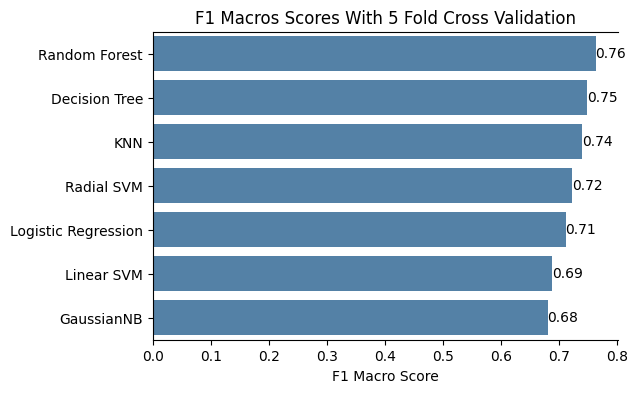

In [24]:
plot.plot_f1_macro(summary,'F1_Macro',summary.index)

We can see the top scorers by the chosen metric. We will take the top performers. Decision Tree classifier will be dropped since Random Forest classifier combines multiple decision trees to reach a single result.
Final three models progressing to hyperparameter tuning : Random Forest, Radial SVM and KNN.

### Hyperparameter tuning

Using GridSearchCV and RandomizedSearchCV to reduce the computational time, the best parameters will be estimated for F1 Macro score. 

#### SVM


In [25]:
pipe_svm = Pipeline(
    [("preprocessor", column_trans), ("classifier", svm.SVC(probability=True))]
)

parameters = {
    "classifier__C": [0.05, 0.1, 0.5, 1, 5, 10, 100],
    "classifier__gamma": [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "classifier__kernel": ["rbf"],
}

gd_svm = RandomizedSearchCV(
    pipe_svm,
    parameters,
    random_state=42,
    scoring="f1_macro",
    n_jobs=-1,
    refit=True,
).fit(X_train, y_train)

gd_svm.best_params_

{'classifier__kernel': 'rbf', 'classifier__gamma': 0.9, 'classifier__C': 5}

#### Random forest

In [26]:
pipe_rf = Pipeline(
    [("preprocessor", column_trans), ("classifier", RandomForestClassifier())]
)

n_estimators = range(100, 1000, 100)
parameters = {
    "classifier__n_estimators": n_estimators,
    "classifier__max_features": ["log2", "sqrt"],
    "classifier__max_depth": [10, 20, 30, 40, 50],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__bootstrap": [True, False],
}

gd_rf = RandomizedSearchCV(
    pipe_rf, parameters, n_jobs=-1, random_state=42, scoring="f1_macro", refit=True
).fit(X_train, y_train)

gd_rf.best_params_

{'classifier__n_estimators': 600,
 'classifier__min_samples_split': 10,
 'classifier__min_samples_leaf': 2,
 'classifier__max_features': 'log2',
 'classifier__max_depth': 10,
 'classifier__bootstrap': False}

#### KNN

In [27]:
pipe_knn = Pipeline(
    [("preprocessor", column_trans), ("classifier", KNeighborsClassifier())]
)

n_neighbors = range(1, 11, 1)
parameters = {"classifier__n_neighbors": n_neighbors}

gd_knn = GridSearchCV(
    pipe_knn, parameters, n_jobs=-1, scoring="f1_macro", refit=True
).fit(X_train, y_train)

gd_knn.best_params_

{'classifier__n_neighbors': 10}

#### Evaluation
Lets have a look at the best scores from optimized models.

In [28]:
tuned_scores = pd.DataFrame(
    {"Tuned_F1_Macro": (gd_svm.best_score_, gd_rf.best_score_, gd_knn.best_score_)},
    index=["Radial SVM", "Random Forest", "KNN"],
)

In [29]:
result_df = pd.merge(
    summary["F1_Macro"], tuned_scores, left_index=True, right_index=True
)
result_df["Improvement_%"] = (
    (result_df["Tuned_F1_Macro"] - result_df["F1_Macro"]) / result_df["F1_Macro"] * 100
)

In [30]:
result_df

,F1_Macro,Tuned_F1_Macro,Improvement_%
Random Forest,0.763340,0.799224,4.700811
KNN,0.740351,0.746762,0.865833
Radial SVM,0.722977,0.766527,6.023677


After hypterparameter tuning all of the models were improved on the selected Macro F1 metric. Radial SVM classificator has the highest improvement percentage ~6%.

### Ensamble model


With the three best performing classifiers selected we can assemble and ensemble model. For this particular task, we will use Voting Classifier with soft voting option to allow classifications algorithms with best probability scores to have higher weights on classifying the instances. We will also tune the model by cycling through voting weights for each classifier in the ensemble

In [31]:
ensemble_model = VotingClassifier(
    estimators=[
        ("KNN", gd_knn.best_estimator_),
        ("RF", gd_rf.best_estimator_),
        ("SVM", gd_svm.best_estimator_),
    ],
    voting="soft",
)

In [32]:
params = {'weights':[(1,1,1), (2,1,1), (1,2,1), (1,1,2)]}
ensemble_model = GridSearchCV(ensemble_model, params,refit=True,n_jobs=-1).fit(X_train, y_train)

In [33]:
y_pred = ensemble_model.predict(X_train)
print(ensemble_model.best_params_)
print(metrics.classification_report(y_train, y_pred))

{'weights': (1, 2, 1)}
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       958
           1       0.93      0.61      0.74       532

    accuracy                           0.84      1490
   macro avg       0.88      0.79      0.81      1490
weighted avg       0.86      0.84      0.83      1490



After tuning the higher weight is given to Random Forest classifier in the ensemble.
Lets have a look at the confusion matrix.

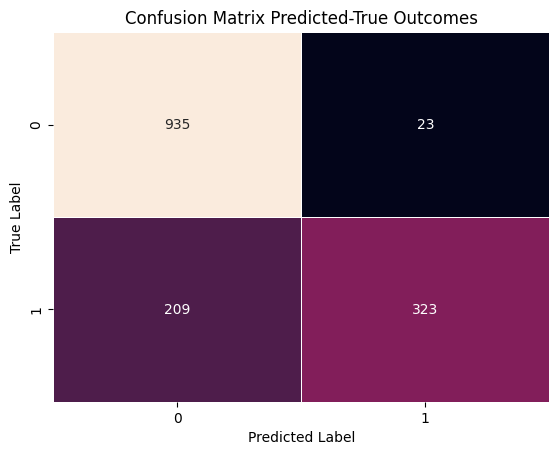

In [34]:
plot.plot_confusion(metrics.confusion_matrix(y_train,y_pred))

The final scores of the Voting Classifier model:

- Macro F1 score: 81%
- Macro Recall: 79%

### Testing the final ensemble model

Finally we will evaluate the ensemble model with the holdout dataset. 

In [35]:
y_pred=ensemble_model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       319
           1       0.82      0.58      0.68       178

    accuracy                           0.80       497
   macro avg       0.81      0.75      0.77       497
weighted avg       0.81      0.80      0.80       497



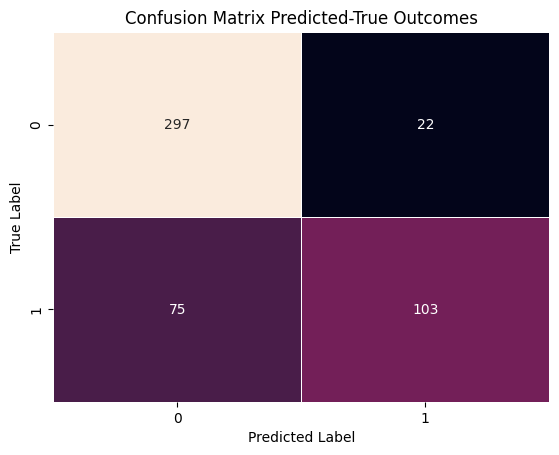

In [36]:
plot.plot_confusion(metrics.confusion_matrix(y_test, y_pred))

The final scores of the Voting Classifier model on test dataset:

- Macro F1 score: 77% (-4% from training)
- Macro Recall: 75% (-4% from training)

Reasonable score difference between prediction on training set and test set indicates that the model was not over-fitting the training set too much.

As stated before since we do not now the preferred strategy of the Insurance company the ensemble model is not further tuned for any specific metric. This could be done using ROC-PR curve or threshold plots.

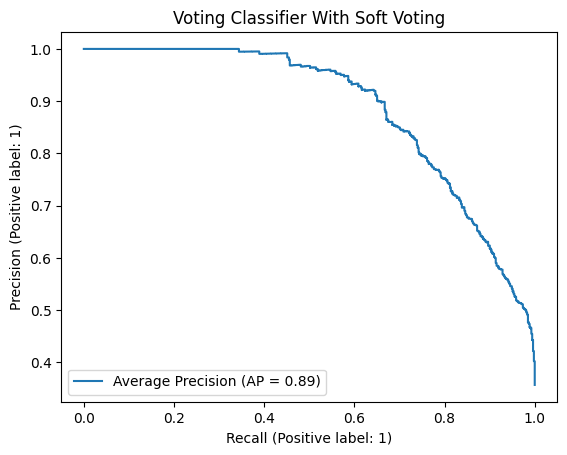

In [37]:
display = PrecisionRecallDisplay.from_estimator(
    ensemble_model, X_train, y_train, name="Average Precision")
display.ax_.set_title("Voting Classifier With Soft Voting");

The ensemble model is a bit of a black box in the current state. Some feature importance analysis is needed to appreciate the inner working of the model. Unfortunately popular tools like SHAP and Lime do not have direct integration of SKlearn ensemble voting or pipeline objects yet and some advanced transformation is needed. To limit the scope of the project at hand we shall leave feature importance analysis for the future.

## Conclusions

The Travel Insurance dataset was analyzed and multiple classification algorithms tested, tuned and assembled into a voting classifier. The classifier was further tuned with voting weights and higher weight was assigned to Random Forest classifier. The final macro scores for the machine learning models:

Baseline model:

- Precision:49%
- F1: 49%
- Accuracy: 53%

Tuned ensemble model:

- Precision: 82%
- Recall: 76%
- F1: 78%
- Accuracy:81% 

Depending on the strategy of the company the project can be re-run focusing on different metric.

## Possible improvements

- Improve pipelines for better abstraction
- Try different scalers
- Perform analysis on final model feature importance
- Use algorithms that utilize boosting
- Create a config file
- Optimize the notebook for better runtime